Tifinagh Character Classification with MLP
Loading sample data...
Applying data augmentation...
Training MLP model...
Epoch 10/100 - Train Loss: 3.5036, Train Acc: 0.0492, Val Loss: 3.5036, Val Acc: 0.0406
Epoch 20/100 - Train Loss: 3.5445, Train Acc: 0.0470, Val Loss: 3.5045, Val Acc: 0.0406
Epoch 30/100 - Train Loss: 3.5496, Train Acc: 0.0430, Val Loss: 3.4954, Val Acc: 0.0406
Epoch 40/100 - Train Loss: 3.5456, Train Acc: 0.0413, Val Loss: 3.5208, Val Acc: 0.0344
Epoch 50/100 - Train Loss: 3.5238, Train Acc: 0.0411, Val Loss: 3.4920, Val Acc: 0.0375
Epoch 60/100 - Train Loss: 3.5032, Train Acc: 0.0411, Val Loss: 3.5668, Val Acc: 0.0344
Epoch 70/100 - Train Loss: 3.4977, Train Acc: 0.0383, Val Loss: 3.4898, Val Acc: 0.0406
Epoch 80/100 - Train Loss: 3.4922, Train Acc: 0.0402, Val Loss: 3.4888, Val Acc: 0.0406
Epoch 90/100 - Train Loss: 3.4921, Train Acc: 0.0392, Val Loss: 3.4882, Val Acc: 0.0406
Epoch 100/100 - Train Loss: 3.4917, Train Acc: 0.0361, Val Loss: 3.4879, Val Acc: 0.0375



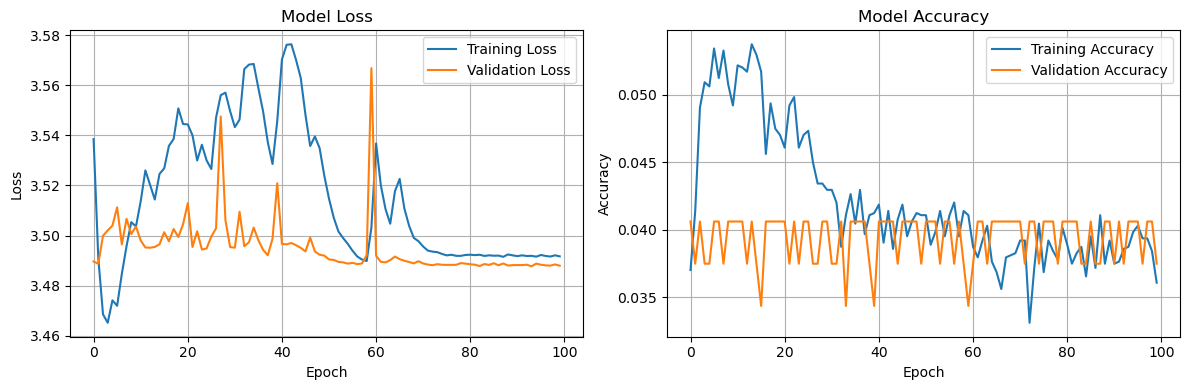


Performing 5-fold cross-validation...
Training fold 1/5
Fold 1 accuracy: 0.0156
Training fold 2/5
Fold 2 accuracy: 0.0195
Training fold 3/5
Fold 3 accuracy: 0.0312
Training fold 4/5
Fold 4 accuracy: 0.0195
Training fold 5/5
Fold 5 accuracy: 0.0430
CV Mean Accuracy: 0.0258 (+/- 0.0201)

Training completed successfully!


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
from scipy.ndimage import rotate
import warnings
warnings.filterwarnings('ignore')

class TifinaghMLP:
    def __init__(self, input_size=1024, hidden1_size=64, hidden2_size=32, output_size=33, 
                 learning_rate=0.01, lambda_reg=0.001, use_adam=True):
        """
        Initialize the MLP for Tifinagh character classification
        
        Args:
            input_size: Input dimension (32x32 = 1024 for flattened images)
            hidden1_size: First hidden layer size
            hidden2_size: Second hidden layer size
            output_size: Number of classes (33 Tifinagh characters)
            learning_rate: Learning rate for optimization
            lambda_reg: L2 regularization parameter
            use_adam: Whether to use Adam optimizer
        """
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.use_adam = use_adam
        
        # Initialize weights and biases
        self.initialize_parameters()
        
        # Adam optimizer parameters
        if self.use_adam:
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.initialize_adam()
            
        # Training history
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    def initialize_parameters(self):
        """Initialize weights using Xavier initialization and biases to zero"""
        np.random.seed(42)
        
        # Xavier initialization
        self.W1 = np.random.randn(self.input_size, self.hidden1_size) * np.sqrt(2.0 / self.input_size)
        self.b1 = np.zeros((1, self.hidden1_size))
        
        self.W2 = np.random.randn(self.hidden1_size, self.hidden2_size) * np.sqrt(2.0 / self.hidden1_size)
        self.b2 = np.zeros((1, self.hidden2_size))
        
        self.W3 = np.random.randn(self.hidden2_size, self.output_size) * np.sqrt(2.0 / self.hidden2_size)
        self.b3 = np.zeros((1, self.output_size))
    
    def initialize_adam(self):
        """Initialize Adam optimizer parameters"""
        # First moment estimates
        self.vdW1 = np.zeros_like(self.W1)
        self.vdb1 = np.zeros_like(self.b1)
        self.vdW2 = np.zeros_like(self.W2)
        self.vdb2 = np.zeros_like(self.b2)
        self.vdW3 = np.zeros_like(self.W3)
        self.vdb3 = np.zeros_like(self.b3)
        
        # Second moment estimates
        self.sdW1 = np.zeros_like(self.W1)
        self.sdb1 = np.zeros_like(self.b1)
        self.sdW2 = np.zeros_like(self.W2)
        self.sdb2 = np.zeros_like(self.b2)
        self.sdW3 = np.zeros_like(self.W3)
        self.sdb3 = np.zeros_like(self.b3)
        
        self.t = 0  # Time step
    
    def relu(self, z):
        """ReLU activation function"""
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        """Derivative of ReLU function"""
        return (z > 0).astype(float)
    
    def softmax(self, z):
        """Softmax activation function with numerical stability"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """Forward propagation through the network"""
        self.A0 = X
        
        # First hidden layer
        self.Z1 = np.dot(self.A0, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        
        # Second hidden layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        
        # Output layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)
        
        return self.A3
    
    def compute_loss(self, y_true, y_pred):
        """Compute cross-entropy loss with L2 regularization"""
        m = y_true.shape[0]
        
        # Cross-entropy loss
        cross_entropy = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = self.lambda_reg / (2 * m) * (
            np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2) + np.sum(self.W3 ** 2)
        )
        
        return cross_entropy + l2_reg
    
    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy"""
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        return np.mean(y_true_labels == y_pred_labels)
    
    def backward_propagation(self, X, y_true, y_pred):
        """Backward propagation to compute gradients"""
        m = X.shape[0]
        
        # Output layer gradients
        dZ3 = y_pred - y_true
        dW3 = np.dot(self.A2.T, dZ3) / m + self.lambda_reg * self.W3 / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        
        # Second hidden layer gradients
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m + self.lambda_reg * self.W2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # First hidden layer gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(self.A0.T, dZ1) / m + self.lambda_reg * self.W1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        return dW1, db1, dW2, db2, dW3, db3
    
    def update_parameters_sgd(self, dW1, db1, dW2, db2, dW3, db3):
        """Update parameters using standard gradient descent"""
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
    
    def update_parameters_adam(self, dW1, db1, dW2, db2, dW3, db3):
        """Update parameters using Adam optimizer"""
        self.t += 1
        
        # Update first moment estimates
        self.vdW1 = self.beta1 * self.vdW1 + (1 - self.beta1) * dW1
        self.vdb1 = self.beta1 * self.vdb1 + (1 - self.beta1) * db1
        self.vdW2 = self.beta1 * self.vdW2 + (1 - self.beta1) * dW2
        self.vdb2 = self.beta1 * self.vdb2 + (1 - self.beta1) * db2
        self.vdW3 = self.beta1 * self.vdW3 + (1 - self.beta1) * dW3
        self.vdb3 = self.beta1 * self.vdb3 + (1 - self.beta1) * db3
        
        # Update second moment estimates
        self.sdW1 = self.beta2 * self.sdW1 + (1 - self.beta2) * (dW1 ** 2)
        self.sdb1 = self.beta2 * self.sdb1 + (1 - self.beta2) * (db1 ** 2)
        self.sdW2 = self.beta2 * self.sdW2 + (1 - self.beta2) * (dW2 ** 2)
        self.sdb2 = self.beta2 * self.sdb2 + (1 - self.beta2) * (db2 ** 2)
        self.sdW3 = self.beta2 * self.sdW3 + (1 - self.beta2) * (dW3 ** 2)
        self.sdb3 = self.beta2 * self.sdb3 + (1 - self.beta2) * (db3 ** 2)
        
        # Bias correction
        vdW1_corrected = self.vdW1 / (1 - self.beta1 ** self.t)
        vdb1_corrected = self.vdb1 / (1 - self.beta1 ** self.t)
        vdW2_corrected = self.vdW2 / (1 - self.beta1 ** self.t)
        vdb2_corrected = self.vdb2 / (1 - self.beta1 ** self.t)
        vdW3_corrected = self.vdW3 / (1 - self.beta1 ** self.t)
        vdb3_corrected = self.vdb3 / (1 - self.beta1 ** self.t)
        
        sdW1_corrected = self.sdW1 / (1 - self.beta2 ** self.t)
        sdb1_corrected = self.sdb1 / (1 - self.beta2 ** self.t)
        sdW2_corrected = self.sdW2 / (1 - self.beta2 ** self.t)
        sdb2_corrected = self.sdb2 / (1 - self.beta2 ** self.t)
        sdW3_corrected = self.sdW3 / (1 - self.beta2 ** self.t)
        sdb3_corrected = self.sdb3 / (1 - self.beta2 ** self.t)
        
        # Update parameters
        self.W1 -= self.learning_rate * vdW1_corrected / (np.sqrt(sdW1_corrected) + self.epsilon)
        self.b1 -= self.learning_rate * vdb1_corrected / (np.sqrt(sdb1_corrected) + self.epsilon)
        self.W2 -= self.learning_rate * vdW2_corrected / (np.sqrt(sdW2_corrected) + self.epsilon)
        self.b2 -= self.learning_rate * vdb2_corrected / (np.sqrt(sdb2_corrected) + self.epsilon)
        self.W3 -= self.learning_rate * vdW3_corrected / (np.sqrt(sdW3_corrected) + self.epsilon)
        self.b3 -= self.learning_rate * vdb3_corrected / (np.sqrt(sdb3_corrected) + self.epsilon)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=True):
        """Train the neural network"""
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            
            epoch_loss = 0
            epoch_acc = 0
            
            # Mini-batch training
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, n_samples)
                
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward propagation
                y_pred = self.forward_propagation(X_batch)
                
                # Compute loss and accuracy
                loss = self.compute_loss(y_batch, y_pred)
                acc = self.compute_accuracy(y_batch, y_pred)
                
                epoch_loss += loss
                epoch_acc += acc
                
                # Backward propagation
                gradients = self.backward_propagation(X_batch, y_batch, y_pred)
                
                # Update parameters
                if self.use_adam:
                    self.update_parameters_adam(*gradients)
                else:
                    self.update_parameters_sgd(*gradients)
            
            # Average loss and accuracy for the epoch
            avg_train_loss = epoch_loss / n_batches
            avg_train_acc = epoch_acc / n_batches
            
            self.history['train_loss'].append(avg_train_loss)
            self.history['train_acc'].append(avg_train_acc)
            
            # Validation
            if X_val is not None and y_val is not None:
                val_pred = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_pred)
                val_acc = self.compute_accuracy(y_val, val_pred)
                
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
                          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    
    def predict(self, X):
        """Make predictions"""
        y_pred = self.forward_propagation(X)
        return np.argmax(y_pred, axis=1)
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        return self.forward_propagation(X)

class DataAugmentation:
    """Data augmentation utilities for Tifinagh characters"""
    
    @staticmethod
    def rotate_images(images, angles):
        """Rotate images by specified angles"""
        augmented = []
        for img in images:
            img_2d = img.reshape(32, 32)
            for angle in angles:
                rotated = rotate(img_2d, angle, reshape=False, mode='constant', cval=0)
                augmented.append(rotated.flatten())
        return np.array(augmented)
    
    @staticmethod
    def translate_images(images, shifts):
        """Translate images by specified pixel shifts"""
        augmented = []
        for img in images:
            img_2d = img.reshape(32, 32)
            for shift_x, shift_y in shifts:
                translated = np.roll(np.roll(img_2d, shift_y, axis=0), shift_x, axis=1)
                augmented.append(translated.flatten())
        return np.array(augmented)
    
    @staticmethod
    def augment_dataset(X, y, rotation_angles=[-10, -5, 5, 10], 
                       translation_shifts=[(-2, 0), (2, 0), (0, -2), (0, 2)]):
        """Apply data augmentation to the dataset"""
        X_augmented = [X]
        y_augmented = [y]
        
        # Add rotations
        if rotation_angles:
            X_rot = DataAugmentation.rotate_images(X, rotation_angles)
            y_rot = np.tile(y, len(rotation_angles))
            X_augmented.append(X_rot)
            y_augmented.append(y_rot)
        
        # Add translations
        if translation_shifts:
            X_trans = DataAugmentation.translate_images(X, translation_shifts)
            y_trans = np.tile(y, len(translation_shifts))
            X_augmented.append(X_trans)
            y_augmented.append(y_trans)
        
        return np.vstack(X_augmented), np.hstack(y_augmented)

def load_sample_data(n_samples=1000):
    """
    Generate sample data for demonstration
    In practice, you would load the AMHCD dataset from Kaggle
    """
    np.random.seed(42)
    
    # Generate synthetic data that mimics Tifinagh character images
    X = np.random.rand(n_samples, 1024)  # 32x32 flattened images
    y = np.random.randint(0, 33, n_samples)  # 33 classes
    
    return X, y

def prepare_data(X, y):
    """Prepare data for training"""
    # Normalize features
    X_normalized = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)
    
    # One-hot encode labels
    y_onehot = np.eye(33)[y]
    
    return X_normalized, y_onehot

def cross_validate(X, y, k_folds=5):
    """Perform k-fold cross-validation"""
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"Training fold {fold + 1}/{k_folds}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Prepare data
        X_train_prep, y_train_prep = prepare_data(X_train_fold, np.argmax(y_train_fold, axis=1))
        X_val_prep, y_val_prep = prepare_data(X_val_fold, np.argmax(y_val_fold, axis=1))
        
        # Train model
        model = TifinaghMLP()
        model.fit(X_train_prep, y_train_prep, X_val_prep, y_val_prep, 
                 epochs=50, verbose=False)
        
        # Evaluate
        val_pred = model.predict(X_val_prep)
        val_acc = accuracy_score(np.argmax(y_val_prep, axis=1), val_pred)
        cv_scores.append(val_acc)
        
        print(f"Fold {fold + 1} accuracy: {val_acc:.4f}")
    
    return cv_scores

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history and len(history['val_loss']) > 0:
        ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
   
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Training Accuracy')
    if 'val_acc' in history and len(history['val_acc']) > 0:
        ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('Model_Accurracy', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Tifinagh Character Classification with MLP")
    print("=" * 50)
    
    # Load and prepare data
    print("Loading sample data...")
    X, y = load_sample_data(n_samples=2000)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Further split training into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Prepare data
    X_train_prep, y_train_prep = prepare_data(X_train, y_train)
    X_val_prep, y_val_prep = prepare_data(X_val, y_val)
    X_test_prep, y_test_prep = prepare_data(X_test, y_test)
    
    # Data augmentation
    print("Applying data augmentation...")
    X_train_aug, y_train_aug = DataAugmentation.augment_dataset(
        X_train, y_train, rotation_angles=[-5, 5], translation_shifts=[(-1, 0), (1, 0)]
    )
    X_train_aug_prep, y_train_aug_prep = prepare_data(X_train_aug, y_train_aug)
    
    # Train model
    print("Training MLP model...")
    model = TifinaghMLP(learning_rate=0.01, lambda_reg=0.001, use_adam=True)
    model.fit(X_train_aug_prep, y_train_aug_prep, X_val_prep, y_val_prep, 
             epochs=100, batch_size=32, verbose=True)
    
    # Evaluate model
    print("\nEvaluating model...")
    test_pred = model.predict(X_test_prep)
    test_acc = accuracy_score(y_test, test_pred)
    
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))
    
    # Plot training history
    plot_training_history(model.history)
    
    # Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv_scores = cross_validate(X_train_prep, y_train_prep, k_folds=5)
    print(f"CV Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    
    print("\nTraining completed successfully!")
 

Tifinagh Character Classification with MLP
Loading sample data...
Applying data augmentation...
Training MLP model...
Epoch 10/100 - Train Loss: 3.5036, Train Acc: 0.0492, Val Loss: 3.5036, Val Acc: 0.0406
Epoch 20/100 - Train Loss: 3.5445, Train Acc: 0.0470, Val Loss: 3.5045, Val Acc: 0.0406
Epoch 30/100 - Train Loss: 3.5496, Train Acc: 0.0430, Val Loss: 3.4954, Val Acc: 0.0406
Epoch 40/100 - Train Loss: 3.5456, Train Acc: 0.0413, Val Loss: 3.5208, Val Acc: 0.0344
Epoch 50/100 - Train Loss: 3.5238, Train Acc: 0.0411, Val Loss: 3.4920, Val Acc: 0.0375
Epoch 60/100 - Train Loss: 3.5032, Train Acc: 0.0411, Val Loss: 3.5668, Val Acc: 0.0344
Epoch 70/100 - Train Loss: 3.4977, Train Acc: 0.0383, Val Loss: 3.4898, Val Acc: 0.0406
Epoch 80/100 - Train Loss: 3.4922, Train Acc: 0.0402, Val Loss: 3.4888, Val Acc: 0.0406
Epoch 90/100 - Train Loss: 3.4921, Train Acc: 0.0392, Val Loss: 3.4882, Val Acc: 0.0406
Epoch 100/100 - Train Loss: 3.4917, Train Acc: 0.0361, Val Loss: 3.4879, Val Acc: 0.0375



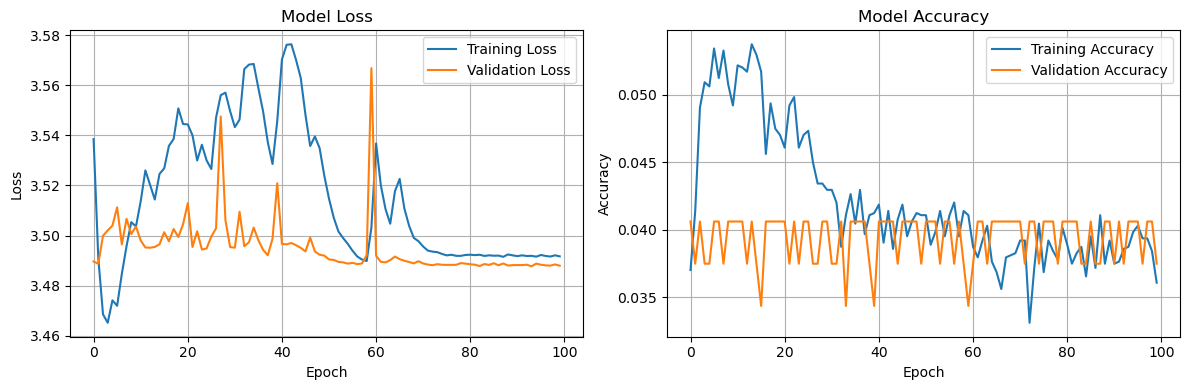


Performing 5-fold cross-validation...
Training fold 1/5
Fold 1 accuracy: 0.0156
Training fold 2/5
Fold 2 accuracy: 0.0195
Training fold 3/5
Fold 3 accuracy: 0.0312
Training fold 4/5
Fold 4 accuracy: 0.0195
Training fold 5/5
Fold 5 accuracy: 0.0430
CV Mean Accuracy: 0.0258 (+/- 0.0201)

Training completed successfully!
Note: Replace load_sample_data() with actual AMHCD dataset loading for real implementation.
